In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import logging
import kagglehub
import os
from datasets import Dataset
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
import sys
print(sys.executable)  # Путь к Python-интерпретатору
!pip list             # Список установленных пакетов

/home/student/kuzin/python_project/TextToSvg_MLCUP/.venv/bin/python3
Package                  Version
------------------------ ----------------
accelerate               1.6.0
asttokens                3.0.0
attrs                    21.2.0
Automat                  20.2.0
Babel                    2.8.0
bcrypt                   3.2.0
bitsandbytes             0.45.3
blinker                  1.4
CacheControl             0.12.10
cachy                    0.3.0
cairocffi                1.7.1
CairoSVG                 2.7.1
certifi                  2020.6.20
cffi                     1.17.1
chardet                  4.0.0
cleo                     0.8.1
click                    8.0.3
clikit                   0.6.2
cloud-init               24.4.1
cmake                    4.0.0
colorama                 0.4.4
command-not-found        0.3
configobj                5.0.6
constantly               15.1.0
crashtest                0.3.1
cryptography             3.4.8
cssselect2               0.7.0
dbus-python

In [2]:
kagglehub.login()


In [3]:
train_df = pd.read_csv("train.csv")

In [4]:
questioins_df = pd.read_parquet("questions.parquet")

In [5]:
#| export

# NOTE the special `#| export` tag above which means all code in this cell will be exported to your Package.
# Make sure to `import` any python packages required by your Model, either here or in other exported cells.

class Model:
    def __init__(self):
        '''Optional constructor, performs any setup logic, model instantiation, etc.'''
        pass
      
    def predict(self, prompt: str) -> str:
        '''Generates SVG which produces an image described by the prompt.

        Args:
            prompt (str): A prompt describing an image
        Returns:
            String of valid SVG code.
        '''
        # Renders a simple circle regardless of input
        return '<svg width="100" height="100" viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red" /></svg>'

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harrabiraouf/scored-svg-11k")

print("Path to dataset files:", path)

Path to dataset files: /home/student/.cache/kagglehub/datasets/harrabiraouf/scored-svg-11k/versions/1


In [7]:
for_fine_tine = pd.read_csv(os.path.join(path, "svg_dataset_scored_11k.csv"))

In [8]:
for_fine_tine.head(5)

,sentence,best_image_score,svg_code
0,An indigo hexagon bloom glistens with morning ...,0.9801,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
1,Sharp mountain silhouettes stand amidst a grad...,0.9849,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
2,A tree composed of interlocking hexagons stand...,0.9965,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
3,Lavender desert stretching endlessly under moo...,0.9975,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
4,"A gradient amber, peach, and cobalt sky over e...",0.9997,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."


In [9]:
temp = [
    {"role": "user", "content": "Which is bigger, the moon or the sun?"},
    {"role": "assistant", "content": "The sun."}
]

In [10]:
def get_sample(row):
    user_content_prompt = f'Generate SVG image from description "{row.sentence[:-1]}"'
    assisnant_content_prompt = f"{row.svg_code}."
    return [{"role": "user", "content": user_content_prompt}, {"role": "assistant", "content": assisnant_content_prompt}]

In [11]:
for_fine_tine["train_data"] = for_fine_tine.apply(get_sample, axis=1)

In [12]:
for_fine_tine.train_data[1:3]

1    [{'role': 'user', 'content': 'Generate SVG ima...
2    [{'role': 'user', 'content': 'Generate SVG ima...
Name: train_data, dtype: object

In [ ]:
for_fine_tine.to_csv("")

In [13]:
model_name = "Qwen/Qwen3-0.6B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    attn_implementation="flash_attention_2"
)

In [14]:
dataset = Dataset.from_dict({"chat": list(for_fine_tine["train_data"])})
dataset = dataset.map(lambda x: {"formatted_chat": tokenizer.apply_chat_template(x["chat"], tokenize=False, add_generation_prompt=False, enable_thinking=False)}, remove_columns=["chat"])

Map:   0%|          | 0/11188 [00:00<?, ? examples/s]

In [15]:
print(dataset['formatted_chat'][0])

<|im_start|>user
Generate SVG image from description "An indigo hexagon bloom glistens with morning dew"<|im_end|>
<|im_start|>assistant
<think>

</think>

<svg xmlns="http://www.w3.org/2000/svg" clip-rule="evenodd" image-rendering="optimizeQuality" shape-rendering="geometricPrecision" text-rendering="geometricPrecision" viewBox="0 0 96 96"><path fill="#fcfcfe" d="M0 0h96v96H0z"/><path fill="#26396d" d="m47 23 19 13 4 18q-9 6-15 14h-4l-4 3q-6-3-8-8h-3q-6-5-9-11 0-9 3-17z"/><path fill="#949db5" d="M48 43q2 0 1 2z"/><path fill="#d7dde6" d="M49 60q2 0 1 3-2-1-1-3"/></svg>.<|im_end|>



In [16]:
dataset = dataset.train_test_split(test_size=0.1)

In [17]:
def preprocess_function(examples):
    return tokenizer([" ".join(x) for x in examples["formatted_chat"]])
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=dataset["train"].column_names,
)

Map (num_proc=4):   0%|          | 0/10069 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1119 [00:00<?, ? examples/s]

Min length: 148
Max length: 47441
Mean length: 2912.0
95th percentile: 6155.200000000001


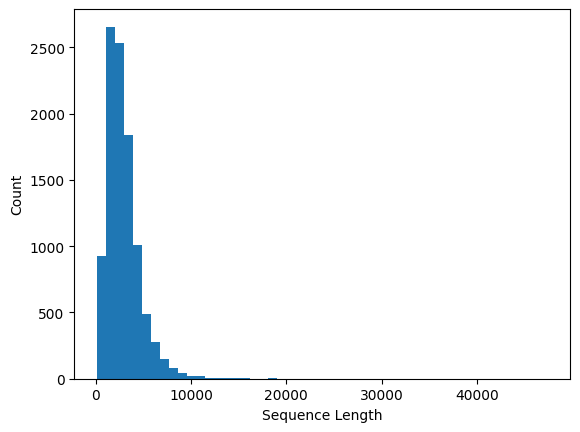

In [31]:
lengths = [len(item["input_ids"]) for item in tokenized_dataset["train"]]

# Статистика
print(f"Min length: {np.min(lengths)}")
print(f"Max length: {np.max(lengths)}")
print(f"Mean length: {np.mean(lengths):.1f}")
print(f"95th percentile: {np.percentile(lengths, 95)}")

# Гистограмма (для Jupyter)
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.show()

In [33]:
tokenized_truncated_dataset = tokenized_dataset.filter(
    lambda example: len(example["input_ids"]) <= 2000,
    batched=False
)

Filter:   0%|          | 0/10069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1119 [00:00<?, ? examples/s]

In [34]:
len(tokenized_truncated_dataset['train']), len(tokenized_dataset['test'])

(3455, 1119)

Min length: 148
Max length: 1999
Mean length: 1372.3
95th percentile: 1942.2999999999997


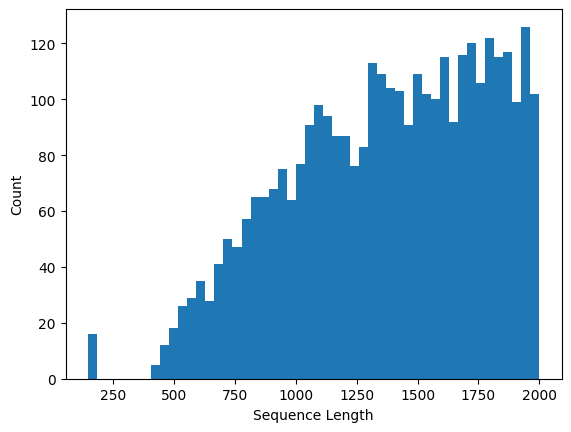

In [35]:
lengths = [len(item["input_ids"]) for item in tokenized_truncated_dataset["train"]]

# Статистика
print(f"Min length: {np.min(lengths)}")
print(f"Max length: {np.max(lengths)}")
print(f"Mean length: {np.mean(lengths):.1f}")
print(f"95th percentile: {np.percentile(lengths, 95)}")

# Гистограмма (для Jupyter)
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.show()

In [36]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


In [37]:
batch = [{"input_ids": [1, 2, 3]}, {"input_ids": [4, 5, 6, 7]}]
collated = data_collator(batch)
collated

{'input_ids': tensor([[     1,      2,      3, 151645],
        [     4,      5,      6,      7]]), 'attention_mask': tensor([[1, 1, 1, 0],
        [1, 1, 1, 1]]), 'labels': tensor([[   1,    2,    3, -100],
        [   4,    5,    6,    7]])}

In [38]:
import torch
print(torch.cuda.is_bf16_supported()) 

True


In [39]:
model.config.use_flash_attn = True

In [40]:
training_args = TrainingArguments(
    output_dir="Qwen/checkpoints",
    eval_strategy="no",
    learning_rate=1e-5,
    weight_decay=0.01,
    bf16 = True,
    push_to_hub=False,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=20,
    save_steps=500,
    logging_steps=10,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    torch_compile=True,
)

In [41]:
torch.cuda.empty_cache()  # Очистка кэша перед обучением

# Уменьшите резервируемую память
torch.backends.cuda.cufft_plan_cache.clear()
PYTORCH_CUDA_ALLOC_CONF="expandable_segments:True"

In [42]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_truncated_dataset["train"],
    eval_dataset=tokenized_truncated_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/tmp/ipykernel_249734/4102243636.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [43]:
trainer.train()

Step,Training Loss
10,0.590200
20,0.586000
30,0.583300
40,0.592900
50,0.574600
60,0.580100
70,0.577000
80,0.581400
90,0.572400
100,0.569700


TrainOutput(global_step=4320, training_loss=0.5430895225869284, metrics={'train_runtime': 9601.061, 'train_samples_per_second': 7.197, 'train_steps_per_second': 0.45, 'total_flos': 2.9263584974104166e+17, 'train_loss': 0.5430895225869284, 'epoch': 20.0})

In [32]:
model.eval()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [31]:
print([len(x) for x in tokenized_dataset["train"][258:260]["input_ids"]])

[1561, 1515]


In [70]:
for_generate = for_fine_tine.train_data[11000][0]
svg = for_fine_tine.train_data[11000][1]
for_generate['content'] = 'Generate SVG from description Lavender desert stretching endlessly under moonlight'

In [71]:
prompt = "Generate from 'Lavender desert stretching endlessly under moonlight' SVG image."

In [72]:
checkpoint_path = "Qwen/checkpoints/checkpoint-430"

In [73]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForCausalLM.from_pretrained(
    checkpoint_path,
    torch_dtype="auto",
    device_map="cuda",
)
model.bfloat16()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [74]:
messages = [
    for_generate
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
)

In [75]:
messages

[{'role': 'user',
  'content': 'Generate SVG from description Lavender desert stretching endlessly under moonlight'}]

In [76]:
text

'<|im_start|>user\nGenerate SVG from description Lavender desert stretching endlessly under moonlight<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n'

In [77]:
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
model_inputs

{'input_ids': tensor([[151644,    872,    198,  31115,  39800,    504,   4008,  42850,   1659,
          23603,  41849,  78737,   1212,  17788,   4145, 151645,    198, 151644,
          77091,    198, 151667,    271, 151668,    271]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [ ]:
model.eval()
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=32000,
)

In [79]:
generated_ids.shape

torch.Size([1, 524])

In [80]:
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

In [81]:
output_ids

[444,
 220,
 220,
 220,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 220,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 220,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 444

In [82]:
# parsing thinking content
try:
    # rindex finding 151668 (</think>)
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

print("thinking content:", thinking_content)
print("content:", content)

thinking content: 
content:  L    L L L L L L L L L L L L  L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L  L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L  L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L L

In [1]:
from cairosvg import svg2png
from io import BytesIO
from PIL import Image
from IPython.display import display
# Ваш SVG-код как строка
svg_data = '''<svg width="256" height="256" viewBox="0 0 256 256" xmlns="http://www.w3.org/2000/svg">
  <!-- ... ваш SVG ... -->
</svg>'''

# Конвертация в PNG в памяти
png_buffer = BytesIO()
svg2png(bytestring=svg_data.encode(), write_to=png_buffer)

# Получение байтов PNG
png_bytes = png_buffer.getvalue()

In [2]:
png_bytes

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x00\x00\x00\x01\x00\x08\x06\x00\x00\x00\\r\xa8f\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00\x01\x15IDATx\x9c\xed\xc11\x01\x00\x00\x00\xc2\xa0\xf5O\xedk\x08\xa0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

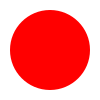

In [1]:
import cairosvg
from io import BytesIO
from PIL import Image

def svg_to_image_in_memory(svg_str):
    """
    Конвертирует SVG-строку в PNG-байты
    """
    svg_plug = '''
    <svg width="100" height="100" xmlns="http://www.w3.org/2000/svg">
      <circle cx="50" cy="50" r="40" fill="red"/>
    </svg>
    '''
    try:
        png_bytes = cairosvg.svg2png(bytestring=svg_str.encode('utf-8'))
    except Exception as e:
        png_bytes = cairosvg.svg2png(bytestring=svg_plug.encode('utf-8'))
    image = Image.open(BytesIO(png_bytes))
    return image

# Пример SVG
svg_string = '''
<svg width="100" height="100" xmlns="http://www.w3.org/2000/svg">
  <circle cx="50" cy="50" r="40" fill="red"/>
'''

# Конвертация
image = svg_to_image_in_memory(None)
display(image)
# Если хочешь загрузить как изображение в памят